In [1]:
import wandb
wandb.login(key="39ded67ba2685c0f85010b40d27298a712244e64")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Preethi\_netrc
wandb: Currently logged in as: mm21b051 (mm21b051-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
wandb.init(project="DeepLearning1", name="GradientDescent")

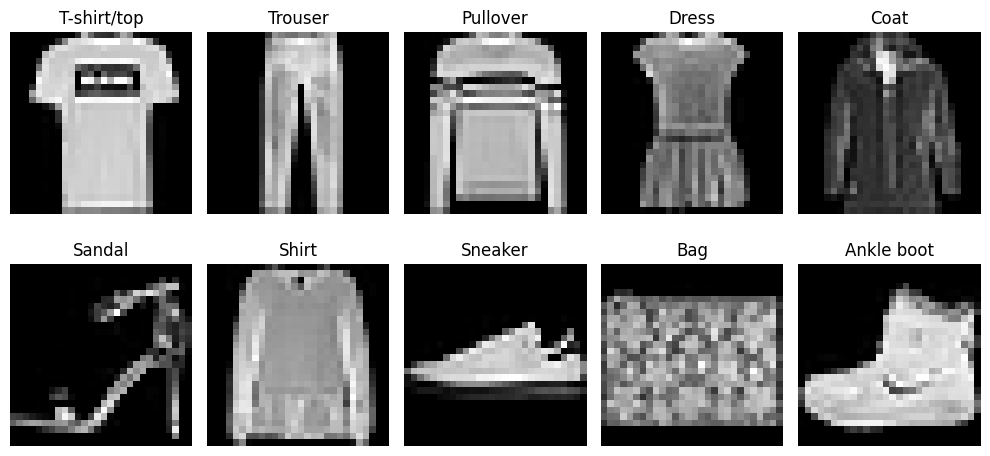

In [3]:
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Defining class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

sample_images = []
sample_labels = []

for class_id in range(10):
    index = np.where(y_train == class_id)[0][0]  # Get the first occurrence of the class
    sample_images.append(x_train[index])
    sample_labels.append(class_names[class_id])

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(sample_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Feed Forward 

In [4]:
import numpy as np
import pandas as pd
import wandb

x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)  # Flatten

# One-hot encoding labels
num_classes = 10
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size):
        """
        Initialize the neural network with given architecture.
        :param input_size: Number of input features
        :param hidden_layers: List where each element is the number of neurons in a hidden layer
        :param output_size: Number of output classes
        """
        self.layers = [input_size] + hidden_layers + [output_size]
        self.weights = {}
        self.biases = {}

        # Initialize weights and biases
        for i in range(len(self.layers) - 1):
            self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            self.biases[i] = np.zeros((1, self.layers[i+1]))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X):
        """
        Forward propagation.
        :param X: Input data
        :return: Activations for each layer
        """
        activations = {0: X}
        for i in range(len(self.layers) - 2):
            Z = np.dot(activations[i], self.weights[i]) + self.biases[i]
            activations[i + 1] = self.relu(Z)
        Z_out = np.dot(activations[len(self.layers) - 2], self.weights[len(self.layers) - 2]) + self.biases[len(self.layers) - 2]
        activations[len(self.layers) - 1] = self.softmax(Z_out)
        return activations

    def backward(self, X, Y, activations, learning_rate):
        """
        Backpropagation algorithm.
        :param X: Input data
        :param Y: True labels
        :param activations: Forward pass activations
        :param learning_rate: Step size for gradient descent
        """
        grads = {}
        m = X.shape[0]
        L = len(self.layers) - 1

        # Compute output layer gradient
        dZ = activations[L] - Y
        grads['dW' + str(L - 1)] = np.dot(activations[L - 1].T, dZ) / m
        grads['db' + str(L - 1)] = np.sum(dZ, axis=0, keepdims=True) / m

        # Backpropagate through hidden layers
        for i in range(L - 2, -1, -1):
            dZ = np.dot(dZ, self.weights[i + 1].T) * self.relu_derivative(activations[i + 1])
            grads['dW' + str(i)] = np.dot(activations[i].T, dZ) / m
            grads['db' + str(i)] = np.sum(dZ, axis=0, keepdims=True) / m

        # Update weights and biases
        for i in range(L):
            self.weights[i] -= learning_rate * grads['dW' + str(i)]
            self.biases[i] -= learning_rate * grads['db' + str(i)]

    def compute_loss(self, Y_true, Y_pred):
        """
        Compute cross-entropy loss.
        """
        m = Y_true.shape[0]
        return -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m

    def train(self, X, Y, epochs=50, batch_size=64, learning_rate=0.01):
        """
        Train the model using mini-batch gradient descent.
        """
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled, Y_shuffled = X[indices], Y[indices]

            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                Y_batch = Y_shuffled[i:i + batch_size]
                activations = self.forward(X_batch)
                self.backward(X_batch, Y_batch, activations, learning_rate)

            # # Log loss to wandb every 10 epochs
            # if epoch % 10 == 0:
            Y_pred = self.forward(X)[len(self.layers) - 1]
            loss = self.compute_loss(Y, Y_pred)
            wandb.log({"epoch": epoch, "loss": loss})
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        """
        Predict class labels.
        """
        activations = self.forward(X)
        return np.argmax(activations[len(self.layers) - 1], axis=1)

# Create and train the network
nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10)
nn.train(x_train, y_train_onehot, epochs=50, batch_size=64, learning_rate=0.01)

# Evaluation on test set
y_pred = nn.predict(x_test)
accuracy = np.mean(y_pred == y_test)
wandb.log({"Test Accuracy": accuracy})  # Log test accuracy
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 0, Loss: 2.3002
Epoch 1, Loss: 2.0391
Epoch 2, Loss: 1.1643
Epoch 3, Loss: 0.9051
Epoch 4, Loss: 0.8116
Epoch 5, Loss: 0.7714
Epoch 6, Loss: 0.7226
Epoch 7, Loss: 0.6443
Epoch 8, Loss: 0.5907
Epoch 9, Loss: 0.5755
Epoch 10, Loss: 0.5573
Epoch 11, Loss: 0.5495
Epoch 12, Loss: 0.5255
Epoch 13, Loss: 0.5185
Epoch 14, Loss: 0.4896
Epoch 15, Loss: 0.4811
Epoch 16, Loss: 0.4775
Epoch 17, Loss: 0.4624
Epoch 18, Loss: 0.4525
Epoch 19, Loss: 0.4351
Epoch 20, Loss: 0.4274
Epoch 21, Loss: 0.4445
Epoch 22, Loss: 0.4350
Epoch 23, Loss: 0.4144
Epoch 24, Loss: 0.4244
Epoch 25, Loss: 0.3946
Epoch 26, Loss: 0.3981
Epoch 27, Loss: 0.3772
Epoch 28, Loss: 0.3920
Epoch 29, Loss: 0.3846
Epoch 30, Loss: 0.4330
Epoch 31, Loss: 0.3682
Epoch 32, Loss: 0.3620
Epoch 33, Loss: 0.3587
Epoch 34, Loss: 0.3481
Epoch 35, Loss: 0.3487
Epoch 36, Loss: 0.3715
Epoch 37, Loss: 0.3355
Epoch 38, Loss: 0.3353
Epoch 39, Loss: 0.3650
Epoch 40, Loss: 0.3439
Epoch 41, Loss: 0.3298
Epoch 42, Loss: 0.3268
Epoch 43, Loss: 0.325

# Different Optimizers

In [5]:
import numpy as np
import wandb
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1) 

num_classes = 10
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, optimizer="sgd", learning_rate=0.01):
        self.layers = [input_size] + hidden_layers + [output_size]
        self.weights = {}
        self.biases = {}

        # initializing weights and biases
        for i in range(len(self.layers) - 1):
            self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            self.biases[i] = np.zeros((1, self.layers[i+1]))

        # Storing gradients and optimization parameters
        self.velocities = {i: np.zeros_like(self.weights[i]) for i in self.weights}
        self.squared_gradients = {i: np.zeros_like(self.weights[i]) for i in self.weights}
        self.m_t = {i: np.zeros_like(self.weights[i]) for i in self.weights}
        self.v_t = {i: np.zeros_like(self.weights[i]) for i in self.weights}

        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.beta1 = 0.9 
        self.beta2 = 0.999
        self.epsilon = 1e-8

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X):
        activations = {0: X}
        for i in range(len(self.layers) - 2):
            Z = np.dot(activations[i], self.weights[i]) + self.biases[i]
            activations[i + 1] = self.relu(Z)
        Z_out = np.dot(activations[len(self.layers) - 2], self.weights[len(self.layers) - 2]) + self.biases[len(self.layers) - 2]
        activations[len(self.layers) - 1] = self.softmax(Z_out)
        return activations

    def backward(self, activations, Y_true):
        grads = {}
        L = len(self.layers) - 1
        m = Y_true.shape[0]

        # gradient for output layer
        dZ = activations[L] - Y_true
        grads['dW' + str(L - 1)] = np.dot(activations[L - 1].T, dZ) / m
        grads['db' + str(L - 1)] = np.sum(dZ, axis=0, keepdims=True) / m

        # Backpropagate through hidden layers
        for i in range(L - 2, -1, -1):
            dZ = np.dot(dZ, self.weights[i + 1].T) * self.relu_derivative(activations[i + 1])
            grads['dW' + str(i)] = np.dot(activations[i].T, dZ) / m
            grads['db' + str(i)] = np.sum(dZ, axis=0, keepdims=True) / m

        return grads

    def update_weights(self, grads, t):
        for i in self.weights:
            if self.optimizer == "sgd":
                self.weights[i] -= self.learning_rate * grads['dW' + str(i)]
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "momentum":
                self.velocities[i] = self.beta1 * self.velocities[i] - self.learning_rate * grads['dW' + str(i)]
                self.weights[i] += self.velocities[i]
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "nesterov":
                prev_velocity = self.velocities[i]
                self.velocities[i] = self.beta1 * self.velocities[i] - self.learning_rate * grads['dW' + str(i)]
                self.weights[i] += -self.beta1 * prev_velocity + (1 + self.beta1) * self.velocities[i]
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "rmsprop":
                self.squared_gradients[i] = self.beta2 * self.squared_gradients[i] + (1 - self.beta2) * (grads['dW' + str(i)] ** 2)
                self.weights[i] -= self.learning_rate * grads['dW' + str(i)] / (np.sqrt(self.squared_gradients[i]) + self.epsilon)
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "adam":
                self.m_t[i] = self.beta1 * self.m_t[i] + (1 - self.beta1) * grads['dW' + str(i)]
                self.v_t[i] = self.beta2 * self.v_t[i] + (1 - self.beta2) * (grads['dW' + str(i)] ** 2)
                m_hat = self.m_t[i] / (1 - self.beta1 ** t)
                v_hat = self.v_t[i] / (1 - self.beta2 ** t)
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

            elif self.optimizer == "nadam":
                m_hat = self.beta1 * self.m_t[i] + (1 - self.beta1) * grads['dW' + str(i)]
                v_hat = self.beta2 * self.v_t[i] + (1 - self.beta2) * (grads['dW' + str(i)] ** 2)
                self.weights[i] -= self.learning_rate * (self.beta1 * m_hat + (1 - self.beta1) * grads['dW' + str(i)] / (1 - self.beta1 ** t)) / (np.sqrt(v_hat / (1 - self.beta2 ** t)) + self.epsilon)
                self.biases[i] -= self.learning_rate * grads['db' + str(i)]

    def compute_loss(self, Y_true, Y_pred):
        m = Y_true.shape[0]
        return -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m

    def train(self, X, Y, epochs=50, batch_size=64):
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled, Y_shuffled = X[indices], Y[indices]

            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                Y_batch = Y_shuffled[i:i + batch_size]
                activations = self.forward(X_batch)
                grads = self.backward(activations, Y_batch)
                self.update_weights(grads, epoch + 1)

            loss = self.compute_loss(Y, self.forward(X)[len(self.layers) - 1])
            wandb.log({"epoch": epoch, "loss": loss})
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

optimizers = ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]

for opt in optimizers:
    wandb.init(project="DeepLearning1", name=f"Optimizer-{opt}", reinit=True)
    print(f"\nTraining with optimizer: {opt}")
    nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10, optimizer=opt, learning_rate=0.001)
    nn.train(x_train, y_train_onehot, epochs=50, batch_size=64)


Test Accuracy,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,0.8692
epoch,49
loss,0.29658



Training with optimizer: sgd
Epoch 0, Loss: 2.3025
Epoch 1, Loss: 2.3023
Epoch 2, Loss: 2.3021
Epoch 3, Loss: 2.3020
Epoch 4, Loss: 2.3017
Epoch 5, Loss: 2.3015
Epoch 6, Loss: 2.3011
Epoch 7, Loss: 2.3006
Epoch 8, Loss: 2.2999
Epoch 9, Loss: 2.2989
Epoch 10, Loss: 2.2973
Epoch 11, Loss: 2.2946
Epoch 12, Loss: 2.2897
Epoch 13, Loss: 2.2794
Epoch 14, Loss: 2.2563
Epoch 15, Loss: 2.2069
Epoch 16, Loss: 2.1337
Epoch 17, Loss: 2.0503
Epoch 18, Loss: 1.9270
Epoch 19, Loss: 1.7541
Epoch 20, Loss: 1.6087
Epoch 21, Loss: 1.4845
Epoch 22, Loss: 1.3833
Epoch 23, Loss: 1.3083
Epoch 24, Loss: 1.2518
Epoch 25, Loss: 1.2068
Epoch 26, Loss: 1.1697
Epoch 27, Loss: 1.1370
Epoch 28, Loss: 1.1084
Epoch 29, Loss: 1.0806
Epoch 30, Loss: 1.0533
Epoch 31, Loss: 1.0292
Epoch 32, Loss: 0.9996
Epoch 33, Loss: 0.9716
Epoch 34, Loss: 0.9445
Epoch 35, Loss: 0.9211
Epoch 36, Loss: 0.9003
Epoch 37, Loss: 0.8853
Epoch 38, Loss: 0.8692
Epoch 39, Loss: 0.8580
Epoch 40, Loss: 0.8503
Epoch 41, Loss: 0.8401
Epoch 42, Loss

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█████████████▇▇▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,49
loss,0.78482



Training with optimizer: momentum
Epoch 0, Loss: 2.2974
Epoch 1, Loss: 1.9331
Epoch 2, Loss: 1.0233
Epoch 3, Loss: 0.8891
Epoch 4, Loss: 0.8221
Epoch 5, Loss: 0.7885
Epoch 6, Loss: 0.6880
Epoch 7, Loss: 0.6286
Epoch 8, Loss: 0.5972
Epoch 9, Loss: 0.5693
Epoch 10, Loss: 0.5684
Epoch 11, Loss: 0.5331
Epoch 12, Loss: 0.5140
Epoch 13, Loss: 0.4995
Epoch 14, Loss: 0.4892
Epoch 15, Loss: 0.4838
Epoch 16, Loss: 0.4667
Epoch 17, Loss: 0.4774
Epoch 18, Loss: 0.4537
Epoch 19, Loss: 0.4426
Epoch 20, Loss: 0.4347
Epoch 21, Loss: 0.4338
Epoch 22, Loss: 0.4201
Epoch 23, Loss: 0.4098
Epoch 24, Loss: 0.4091
Epoch 25, Loss: 0.4001
Epoch 26, Loss: 0.3892
Epoch 27, Loss: 0.4027
Epoch 28, Loss: 0.3781
Epoch 29, Loss: 0.3745
Epoch 30, Loss: 0.3754
Epoch 31, Loss: 0.3650
Epoch 32, Loss: 0.3632
Epoch 33, Loss: 0.3708
Epoch 34, Loss: 0.3562
Epoch 35, Loss: 0.3465
Epoch 36, Loss: 0.3441
Epoch 37, Loss: 0.3367
Epoch 38, Loss: 0.3336
Epoch 39, Loss: 0.3367
Epoch 40, Loss: 0.3221
Epoch 41, Loss: 0.3243
Epoch 42,

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
loss,0.30448



Training with optimizer: nesterov
Epoch 0, Loss: 2.3001
Epoch 1, Loss: 2.0639
Epoch 2, Loss: 1.1614
Epoch 3, Loss: 0.9190
Epoch 4, Loss: 0.8584
Epoch 5, Loss: 0.8231
Epoch 6, Loss: 0.7985
Epoch 7, Loss: 0.7157
Epoch 8, Loss: 0.6414
Epoch 9, Loss: 0.5971
Epoch 10, Loss: 0.5856
Epoch 11, Loss: 0.5547
Epoch 12, Loss: 0.5378
Epoch 13, Loss: 0.5217
Epoch 14, Loss: 0.5124
Epoch 15, Loss: 0.4973
Epoch 16, Loss: 0.4877
Epoch 17, Loss: 0.4857
Epoch 18, Loss: 0.4744
Epoch 19, Loss: 0.4596
Epoch 20, Loss: 0.4680
Epoch 21, Loss: 0.4408
Epoch 22, Loss: 0.4362
Epoch 23, Loss: 0.4295
Epoch 24, Loss: 0.4283
Epoch 25, Loss: 0.4244
Epoch 26, Loss: 0.4066
Epoch 27, Loss: 0.4026
Epoch 28, Loss: 0.3958
Epoch 29, Loss: 0.4073
Epoch 30, Loss: 0.3950
Epoch 31, Loss: 0.3885
Epoch 32, Loss: 0.3765
Epoch 33, Loss: 0.3891
Epoch 34, Loss: 0.3742
Epoch 35, Loss: 0.3602
Epoch 36, Loss: 0.3560
Epoch 37, Loss: 0.3510
Epoch 38, Loss: 0.3535
Epoch 39, Loss: 0.3453
Epoch 40, Loss: 0.3489
Epoch 41, Loss: 0.3455
Epoch 42,

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
loss,0.31797



Training with optimizer: rmsprop
Epoch 0, Loss: 0.4247
Epoch 1, Loss: 0.3711
Epoch 2, Loss: 0.3337
Epoch 3, Loss: 0.3381
Epoch 4, Loss: 0.2999
Epoch 5, Loss: 0.3061
Epoch 6, Loss: 0.3423
Epoch 7, Loss: 0.3096
Epoch 8, Loss: 0.2634
Epoch 9, Loss: 0.2594
Epoch 10, Loss: 0.2409
Epoch 11, Loss: 0.2343
Epoch 12, Loss: 0.2385
Epoch 13, Loss: 0.2291
Epoch 14, Loss: 0.2192
Epoch 15, Loss: 0.2164
Epoch 16, Loss: 0.2157
Epoch 17, Loss: 0.2122
Epoch 18, Loss: 0.2047
Epoch 19, Loss: 0.1968
Epoch 20, Loss: 0.1973
Epoch 21, Loss: 0.1912
Epoch 22, Loss: 0.1834
Epoch 23, Loss: 0.1937
Epoch 24, Loss: 0.2049
Epoch 25, Loss: 0.1985
Epoch 26, Loss: 0.1684
Epoch 27, Loss: 0.1704
Epoch 28, Loss: 0.1923
Epoch 29, Loss: 0.1644
Epoch 30, Loss: 0.2044
Epoch 31, Loss: 0.1951
Epoch 32, Loss: 0.1663
Epoch 33, Loss: 0.1488
Epoch 34, Loss: 0.1745
Epoch 35, Loss: 0.1502
Epoch 36, Loss: 0.1606
Epoch 37, Loss: 0.1552
Epoch 38, Loss: 0.1537
Epoch 39, Loss: 0.1489
Epoch 40, Loss: 0.1356
Epoch 41, Loss: 0.1429
Epoch 42, 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▃▃▂▂▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂
epoch,49
loss,0.1244



Training with optimizer: adam
Epoch 0, Loss: 0.5467
Epoch 1, Loss: 0.4955
Epoch 2, Loss: 0.4581
Epoch 3, Loss: 0.4373
Epoch 4, Loss: 0.4265
Epoch 5, Loss: 0.4088
Epoch 6, Loss: 0.4000
Epoch 7, Loss: 0.3896
Epoch 8, Loss: 0.3954
Epoch 9, Loss: 0.3760
Epoch 10, Loss: 0.3703
Epoch 11, Loss: 0.3615
Epoch 12, Loss: 0.3560
Epoch 13, Loss: 0.3502
Epoch 14, Loss: 0.3435
Epoch 15, Loss: 0.3395
Epoch 16, Loss: 0.3372
Epoch 17, Loss: 0.3356
Epoch 18, Loss: 0.3264
Epoch 19, Loss: 0.3274
Epoch 20, Loss: 0.3197
Epoch 21, Loss: 0.3188
Epoch 22, Loss: 0.3113
Epoch 23, Loss: 0.3087
Epoch 24, Loss: 0.3040
Epoch 25, Loss: 0.3003
Epoch 26, Loss: 0.2963
Epoch 27, Loss: 0.2926
Epoch 28, Loss: 0.2994
Epoch 29, Loss: 0.2886
Epoch 30, Loss: 0.2851
Epoch 31, Loss: 0.2803
Epoch 32, Loss: 0.2868
Epoch 33, Loss: 0.2778
Epoch 34, Loss: 0.2702
Epoch 35, Loss: 0.2679
Epoch 36, Loss: 0.2717
Epoch 37, Loss: 0.2727
Epoch 38, Loss: 0.2608
Epoch 39, Loss: 0.2729
Epoch 40, Loss: 0.2636
Epoch 41, Loss: 0.2585
Epoch 42, Los

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,49
loss,0.23149



Training with optimizer: nadam
Epoch 0, Loss: 0.5965
Epoch 1, Loss: 0.5201
Epoch 2, Loss: 0.5339
Epoch 3, Loss: 0.6372
Epoch 4, Loss: 0.6763
Epoch 5, Loss: 0.6668
Epoch 6, Loss: 0.7095
Epoch 7, Loss: 0.8105
Epoch 8, Loss: 0.8313
Epoch 9, Loss: 0.7821
Epoch 10, Loss: 0.8281
Epoch 11, Loss: 0.8458
Epoch 12, Loss: 0.9268
Epoch 13, Loss: 0.9297
Epoch 14, Loss: 1.1763
Epoch 15, Loss: 1.1860
Epoch 16, Loss: 0.9441
Epoch 17, Loss: 1.0165
Epoch 18, Loss: 0.9367
Epoch 19, Loss: 0.9160
Epoch 20, Loss: 1.0906
Epoch 21, Loss: 1.1326
Epoch 22, Loss: 1.2764
Epoch 23, Loss: 1.0408
Epoch 24, Loss: 1.0265
Epoch 25, Loss: 1.1792
Epoch 26, Loss: 1.0270
Epoch 27, Loss: 1.0534
Epoch 28, Loss: 1.2105
Epoch 29, Loss: 1.5464
Epoch 30, Loss: 1.3060
Epoch 31, Loss: 1.8762
Epoch 32, Loss: 1.4756
Epoch 33, Loss: 1.3319
Epoch 34, Loss: 1.3216
Epoch 35, Loss: 1.1289
Epoch 36, Loss: 2.1217
Epoch 37, Loss: 2.8746
Epoch 38, Loss: 4.1611
Epoch 39, Loss: 3.4812
Epoch 40, Loss: 4.0734
Epoch 41, Loss: 3.0471
Epoch 42, Lo

In [6]:
print(wandb.run.get_url())


https://wandb.ai/mm21b051-iitmaana/DeepLearning1/runs/avvhujgh


In [8]:
from IPython.display import display, HTML
display(HTML("<script src='https://wandb.ai/mm21b051-iitmaana/DeepLearning1?nw=nwusermm21b051&panelDisplayName=loss&panelSectionName=Charts'></script>"))

In [13]:
from IPython.display import Image

# Fetch and display an image logged in W&B
run = wandb.Api().run("mm21b051-iitmaana/DeepLearning1/runs/avvhujgh")
image = run.summary["loss"]  # Replace "loss" with the exact logged key
display(Image(image))


FileNotFoundError: No such file or directory: '4.828471760469'

FileNotFoundError: No such file or directory: '4.828471760469'

<IPython.core.display.Image object>

In [14]:
print(run.summary)  # Check all available keys
print(run.summary.get("loss"))  # See what "loss" contains


{'loss': 4.828471760469, '_runtime': 522.2501912, '_step': 49, '_timestamp': 1741889327.2008967, '_wandb': {'runtime': 522}, 'epoch': 49}
4.828471760469


In [12]:
import wandb

api = wandb.Api()
runs = api.runs("mm21b051-iitmaana/DeepLearning1")

for run in runs:
    print(run.name, run.id)  # Print available runs


GradientDescent og8bzw7h
GradientDescent ujf8mom4
GradientDescent x5tu2qu8
Optimizer-sgd bcljk5fp
Optimizer-sgd zx3lx194
Optimizer-momentum n03da1y5
Optimizer-nesterov fxtjq98y
Optimizer-rmsprop kku48rfu
Optimizer-adam 64ji7nct
Optimizer-nadam w9g606ho
valiant-sweep-1 z3acx5w1
scarlet-sweep-2 hh9jknk6
super-sweep-3 g2x41ilq
northern-sweep-4 8zzefm5i
crimson-sweep-5 3m6jv11g
blooming-sweep-6 dlshzqjk
rare-sweep-7 bcq43l88
golden-sweep-8 6h41sotj
crimson-sweep-9 qr8my80f
happy-sweep-10 3k08hhfc
hl_4_bs_64_ac_tanh ekh5ksaw
polished-sweep-2 1g2ejv4f
hl_3_bs_32_ac_relu 4jz37hzb
hl_3_bs_64_ac_tanh kiubvsoq
hl_5_bs_64_ac_relu t3lw3yy7
hl_4_bs_16_ac_relu nu6n647j
hl_4_bs_16_ac_sigmoid iq8byhub
hl_5_bs_32_ac_relu qrqwa0w9
hl_5_bs_64_ac_relu zdov0kkx
hl_3_bs_64_ac_relu 0dgil7se
hl_4_bs_64_ac_relu o4g7lenl
hl_4_bs_32_ac_relu rgcn40p2
hl_3_bs_32_ac_relu hmcepv2z
hl_5_bs_32_ac_relu tekkh0x5
hl_4_bs_32_ac_relu 7uh4y8dp
hl_3_bs_64_ac_relu ets43m7d
hl_5_bs_64_ac_relu jqq0ypl0
hl_5_bs_32_ac_relu e89fle

KeyboardInterrupt: 